# <i>COMXXX - Computers and Music</i> <br /> <br />  <b>Equalization</b> 
<div align="right"><a href="link">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

In [7]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.io import wavfile
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal
import import_ipynb
import Helpers
import matplotlib

In [4]:
figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})
fs=44100

In this notebook, we are going to implement 3 of the most basic and important frequency filters that are used in audio production. When combined, these filters allow to shape a filter virtually any frequency response. Such a filter is called an **Equalizer (EQ)** and is essential for the production of any audio track. 

# 1. The Fundamental Filters

## 1.1. The notch filter

The first filter we will see is called the **Notch filter**. It gets rid of one selected frequency in the audio. It is generally used to remove a buzzing noise with constant frequency. For instance, home amplifiers often produce a buzzing noise around 50Hz, the frequency of the alternating current. This noise can be deleted by placing a notch filter at 60Hz in the amplifier.

Generally, 2 parameters are used to control a notch filter:
- The cutoff frequency $\omega_c$ which is going to be eliminated
- The quality factor $Q$ which defines how sharp or broad the filter will be around $\omega_c$.

<p style="color:red;">The meaning of Q in analog filter design is a bit different (see https://en.wikipedia.org/wiki/Q_factor). I haven't yet found a precise equivalence in the discrete-time domain so maybe we should clarify this. see also the answers in https://dsp.stackexchange.com/questions/19148/whats-the-q-factor-of-a-digital-filters-pole (PP)</p>


A notch can be simply implemented as a second order filter where a zero is placed on the unit circle at $\omega_c$, and another zero is also placed symmetrically at $-\omega_c$. A pole is placed next to each zero, inside of the unit circle in order to keep stability, and the distance from the pole to the circle is determined by $Q$: the closest the pole to the circle, the sharpest the filter. The frequency response of a notch can be written as 

$$
H(z) =\frac{1 - 2 \cos \omega_c z^{-1} + z^{-2}}{1 - 2 Q \cos \omega_c z^{-1} + Q^2 z^{-2}} .
$$

Note the the frequency $\omega_c$ is an angular frequency, taking values between $0$ and $\pi$. $Q$ takes values between 0 and 1, where 0 means that the filter is maximally broad (that is, an allpass), and 1 meaning that only the exact frequency is removed. Let's now implement it!

In [5]:
def notch(x, wc, Q=0.99, pole=False):
    '''
    Notch filter taking an audio signal 'x' and returning its filtered version.
    x: the input signal
    wc: the cutoff angular frequency
    Q: the quality factor
    pole: when set to True, plots the filter's pole-zero plot and frequency response. when set to False, return the filtered signal
    '''
    # Define the numerator and the denominator of the transfer function
    b = np.array((1,  -2 * np.cos(wc), 1))
    a = np.array((1, - 2 * Q * np.cos(wc), Q**2 ))
    
    # Plot pole-zero and frequency response when True
    if pole==True:
        freq_response(b,a)
        return zplane(b,a)
    
    # Create filter from transfer function and normalize
    x = lfilter(b, a, x)
    return x / np.max(np.abs(x))

We can now plot the pole-zero plot and the frequency (and phase) responses of the filter. We remark that the frequency looks like a rather flat line with two negative poles tending to zero (the notches) centered on the cutoff frequency. 

The pole-zero plot has 2 poles and 2 zeros, positionned as explained before. Try to change the values of $\omega_c$ and $Q$ and obersve how the pole and zeros move. One can observe that the gain factor $G$ is not observable on the ploe-zero plot.

<p style="color:red;">I tend to find linear scale graphs more interesting... maybe both? (PP)</p>


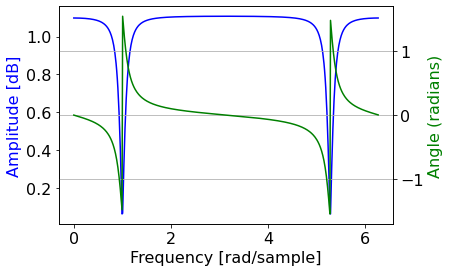

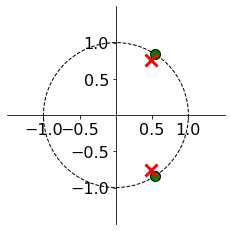

In [6]:
notch(np.ones(1), 1, Q=0.9, pole=True);

## 1.2. The shelf filter

The second filter we will implement is the shelf filter. This filter exists in 2 versions, low shelf and high shelf. A low shelf filter increases all the frequencies below the cutoff frequency $\omega_c$ by a gain factor $G$. The frequencies above $\omega_c$ and left unchanged. A high shelf does the same the other way around. The filters take 3 arguments: $\omega_c$, $G$, and the type of shepf (high or low).

The shelf filter has a slightly different implementation for its high and low variant. The low variant is composed of one pole and one zero that move on the real axis within the unit circle. The pole is always on the right of the zero. When the cutoff frequency $\omega_c$ increases, both the pole and the zero move to the left, having less influence on the low frequencies and more on the high frequencies. The transfer function can be written as

$$
 H(z) = \frac{ G \tan (\omega_c / 2) + \sqrt{G} + (G \tan ( \omega_c / 2 ) - \sqrt{G} ) z^{-1}}{\tan (\omega_c / 2) + \sqrt{G} + (\tan ( \omega_c / 2 ) - \sqrt{G} ) z^{-1}} .
$$

The high shelf filter is basically the same, except that the pole and the zero have exchanged places, and the zero is now on the right of the pole. The transfer function is obtain by replacing $G$ with $1/G$ in the low shelf filter's, and subsequently multiplying it with $G$.

In [ ]:
def shelf(x, wc, G=2, band="low", pole=False):
    '''
    First order shelf filter.
    x: input signal
    wc: cutoff frequency
    G: the gain factor
    band: the choice between "high" and "low" shelf filter
    pole: when set to True, plots the filter's pole-zero plot and frequency response. when set to False, return the filtered signal
    '''
    # Design the transfer function for both versions of shelf filter
    if band=="low":
        b = np.array(((G * np.tan(wc/2) + np.sqrt(G)), (G* np.tan(wc/2)-np.sqrt(G))))
        a = np.array((np.tan(wc/2) + np.sqrt(G),(np.tan(wc/2)-np.sqrt(G))))
    if band=="high":
        b = np.array(((np.sqrt(G) * np.tan(wc/2) + G), (np.sqrt(G)* np.tan(wc/2)-G)))
        a = np.array((np.sqrt(G) * np.tan(wc/2) + 1,(np.sqrt(G)*np.tan(wc/2)-1)))
        
    # Plot pole-zero and frequency response when True
    if pole==True:
        print(b, a)
        freq_response(b,a)
        return zplane(b,a)
        
    # Create filter from transfer function and normalize
    x = lfilter(b, a, x)
    return x / np.max(np.abs(x))

We can now observe the effect of $G$ and $\omega_c$ on the frequency response and the pole-zero plot. 

In [ ]:
shelf(np.ones(1), 1, 2, "low", pole=True);

## 1.3. The cut filter (or pass filter)

The lowcut, resp. highcut filters (also commonly called highcut, resp. lowcut) are a family of filters that eliminate all frequencies below, resp. above a given cutoff frequency $\omega_c$. They are used to get rid of the unwanted frequencies outside of the working range. For instance, when recording a guitar, that typically produces sounds between 80 and 5000 Hz, a producer may want to use a lowcut and highcut filters to get rid of all the sound captured ooutside this range. An increasing lowcut filter is also often used by DJs to create a suspense effect before a bass drop, reducing the frequencies of the music to only the highest pitches, before letting back all of the frequencies at once to create the drop.

One of the simplest implementation of the cut filters is a first order implementation, consisting of one zero and one pole. The zero is stationary and is located one the unit circle at angle 0 for the lowcut filter, and angle $\pi$ for the highcut, in order to make sure that the frequencies at the low, resp. high end of the spectrum are eliminated. A pole is positioned on the real axis to control how fast or slow the frequencies should reach 0 in the neighbourhoud of the zero, depeding on the cutoff frequency $\omega_c$.

The transfer function of an highcut (lowpass) filter is written as
$$
    H(z) = \frac{1+\alpha}{2} \left( \frac{1 + z^{-1}}{1- \alpha z^{-1}} \right)
$$
where
$$
    \alpha = \frac{1-\sin(\omega_c) }{\cos(\omega_c)}.
$$

In [ ]:
def cut(x, wc, band="low", pole=False):
    '''
    Cut (pass) filter.
    x: input signal
    wc: cutoff frequency
    band: type of filter, "high" or "low"
    pole: when set to True, plots the filter's pole-zero plot and frequency response. when set to False, return the filtered signal
    '''
    alpha = (1-np.sin(wc))/np.cos(wc)
   
    # Design the transfer function for both versions of cut filter
    if band=="high":
        b = 0.5 * np.array([1-alpha, 1-alpha])
    if band=="low":
        b = 0.5 * np.array([1+alpha, -1-alpha])
    
    a = np.array([1, -alpha])
    
    # Plot pole-zero and frequency response when True
    if pole==True:
        print(b, a)
        freq_response(b,a)
        return zplane(b,a)
        
    # Create filter from transfer function and normalize
    x = lfilter(b, a, x)
    return x / np.max(np.abs(x))

We can now play with the parameter and observe how the transition evolves. We remark that this simple first-order pass filters always have a transition from a gain of 1 to a gain of 0 (or the other way around). The only change that occurs when moving the cutoff frequency is how fast the transition happens as the frequencies increase.

In [ ]:
cut(np.ones(1), .2, "low", pole=True);

# 2. Testing with a guitar sample

## 2.1. Notch filter

Okay, we can now test our filter on a real example of guitar recording! First, let's listen to the recording without EQ.

<p style="color:red;">the code below assumes mono, int16 data. be careful that people may use different formats. We should provide in the helpers a more generic function to load audio files and convert them to a mono float array (PP)</p>


In [ ]:
fs, data = wavfile.read('samples/guitar.wav')
guitar_sample = np.array(data, dtype=np.float32)
guitar_sample /= np.max(np.abs(guitar_sample) )
plt.figure(figsize=figsize)
plt.xscale("log")
plt.plot(np.real(fft(guitar_sample))[100:50000])
Audio("samples/guitar.wav", autoplay=False)

<p style="color:red;">Not sure that plotting the FFT of the audio sample in log freq scale is very clear. at least it took me a while to understand it was a frequency plot :D (PP)</p>


In [ ]:
plt.plot(guitar_sample)

We can now test our notch filter. Let's say our guitar was connected to an amplifier that produces a buzzing sound at 60Hz. This can be modeled by simply adding a AGWN to the signal.

<p style="color:red;">My understanding was that a parasitic hum is a sinusoidal component rather than a narrowband white noise... After all, the frequency of home AC is so precise that it is often used as a reference clock, no?(PP)</p>


In [ ]:
buzzing = butter_pass_filter(np.random.random(guitar_sample.size), np.array([155, 165]), fs, "band", order=7)
guitar_buzzing = guitar_sample+10*buzzing
guitar_buzzing /= np.max(np.abs(guitar_buzzing) )

plt.figure(figsize=figsize)
plt.plot(np.real(fft(guitar_buzzing))[100:50000], label="Guitar+buzz")
plt.plot(np.real(fft(10*buzzing))[100:50000], label="Buzz")
plt.xscale("log")
plt.legend()
wavfile.write('samples/guitar_buzz.wav', fs, (0x7FFF * guitar_buzzing).astype(np.int16))
Audio("samples/guitar_buzz.wav", autoplay=False)

To get rid of it, we apply the notch filter with a frequency of 160Hz. We first convert 160Hz into an angular frequency using a rule of 3, and we choose a high quality factor to damage as least as possible the neighbouring frequencies of the buzzing sound. The frequency of the notch filter is plotted in red below.

In [ ]:
guitar_notch = notch(guitar_buzzing, 160*(2*np.pi)/fs, Q=.994)

plt.figure(figsize=figsize)
plt.plot(np.real(fft(guitar_notch))[100:50000])
plt.xscale("log")
plt.vlines(np.array([160])*guitar_sample.size/fs, -2000, 2000, color="red")
wavfile.write('samples/guitar_notch.wav', fs, (0x7FFF * guitar_notch).astype(np.int16))
Audio("samples/guitar_notch.wav", autoplay=False)

The buzzing sound is gone!

## 2.2 Shelf filters

Now let's move to the shelf filters. Let's assume we only want to boost the bass to mid range of the guitar, to give it a warmer sound. The cutoff frequecy of the shelf filter is plotted in red below. Note that when filtering a sound with a shelf filter, all frequencies change, since the global maximum amplitude is generally wanted to be 1. The "untouched" frequencies are then reduced while the "amplified" frequencies gain a bigger amplitude.

In [ ]:
guitar_shelf = shelf(guitar_sample, 100*(2*np.pi)/fs, 15, "low")

plt.figure(figsize=figsize)
plt.xscale("log")
plt.plot(np.real(fft(guitar_shelf))[100:50000], label="Shelved guitar")
plt.plot(np.real(fft(guitar_sample))[100:50000], alpha=.5, label="Dry guitar")
plt.vlines(np.array([100])*guitar_sample.size/fs, -2000, 2000, color="red")
plt.legend()
wavfile.write('samples/guitar_shelf.wav', fs, (0x7FFF * guitar_shelf).astype(np.int16))
Audio("samples/guitar_shelf.wav", autoplay=False)

## 2.3 Cut filters

Finally, let's use the cut filters. A guitar typically spans from 80 to 5000Hz. We can then get rid of all the other frequencies by subsequently applying a lowcut and a highcut filter. In the plot below, the 2 cutoff frequencies of the low and highcut filters are plotted in red. The result may not by shockingly distinct from the original recording, since the removed frequencies are not produced by the guitar itself, but may mostly come from ambient noises and artifacts of the amplifier. However, when mixing the guitar down with other intruments, keeping these unwanted (although discrete) out of range frequencies may quickly lead to a muddy mix.

In [ ]:
plt.figure(figsize=figsize)
plt.xscale("log")
plt.plot(np.real(fft(guitar_sample))[:int(guitar_sample.size/2)], label="Dry guitar")
plt.plot(np.real(fft(guitar_cut))[:int(guitar_sample.size/2)], label="Cut guitar")
plt.vlines(np.array([80,3000])*guitar_sample.size/fs, -2000, 2000, color="red")
plt.legend()
plt.show()

That's it, we now have the basic ingredients to a basic EQ for music production. By combining these effects on several tracks, it is possible to create a clean mix! Have fun trying!